Linear Regression
=================
1. Problem setup
---------------

Let $f(x)$ be the __unknown__ target function we wish to learn, and let $D = \{(x_1, y_1), (x_2, y_2), .., (x_N, y_N)\}$ be the set of input-output examples we have.
We want to use machine learning to find a hypothesis $g$ that approximates the real target function $f$.

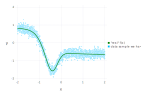

In [1]:
using Gadfly

NUMPOINTS = 2000
x_data = 4*(rand(NUMPOINTS)-0.5)
F_x = 1.8*tanh(3.2*x_data + 0.8)- 2.5*tanh(2.1*x_data + 1.2)-0.2*tanh(0.1*x_data - 0.5)
noise = 0.2*std(F_x)
y_data =  F_x + noise*randn(size(x_data))

plot(layer(x=x_data, y=F_x, Geom.line, Theme(line_width=1.5pt, default_color = colorant"green")), 
     layer(x=x_data, y=y_data, Geom.point, Theme(default_point_size=1.3pt, default_color = colorant"deepskyblue")),
     Guide.manual_color_key("", ["\"real\" f(x)", "data sample we have"], ["green", "deepskyblue"]))

It is important to note that the data we have does not represent a deterministic function. Instead, it is a noisy target function formalized as a distribution that comes from adding noise to the "real" function $f$. In other words, we have an _unknown_ distribution $P(x,y)$ that generates each point $(x_N,y_N)$, and __we now want to find a hypothesis g that minimizes the error between $g(x)$ and $y$ with respect to that distribution__. 

2. Finding $g$
--------------
The linear regression algorithm is based on __minimizing the squared error between out hypothesis $h(x)$ and $y$__:

$$E_{out}(h) = E [(h(x) - y)^2]$$

where the expected value is taken with respect to the joint probability distribution $P(x, y)$. Since the distribution $P(x,y)$ is unknown, $E_{out}$ cannot be computed. So we resort to the in-sample error:

$$E_{in}(h) = \frac{1}{N} \sum_{n=1}^{N} (h(x_n) - y_n)^2 \tag{1}$$

In linear regression, $h$ takes the form of a linear combination of the components of x. That is,
$$h(x) = \sum_{i=0}^{d} (w_i x_i)= \mathbf{w^T x} $$

We now have,
$$E_{in}(h) = \frac{1}{N} \sum_{n=1}^{N}(\mathbf{w^T x_n} - y_n)^2 \tag{2}$$

$$ = \frac{1}{N} \lVert \mathbf{Xw - y} \rVert^2 $$

$$ = \frac{1}{N} (\mathbf{w^TX^TXw -2w^TX^Ty + y^Ty}) \tag{3}$$

Then the linear regression algorithm is derived by minimizing $E_{in}(\mathbf{w})$ over all possible $\mathbf{w} \in \mathbb{R}^{d+1}$.
We can find the $\mathbf{w}$ that minimizes $E_{in}(\mathbf{w})$ by requiring that the gradient of $E_{in}$ with respect to $\mathbf{w}$ is the zero vector, i.e., $\nabla E_{in}(\mathbf{w}) = 0$.
The gradient is a column vector whose $i$th component is $[\nabla E_{in}(\mathbf{w})]_i = \frac{\delta}{\delta w_i}E_{in}(\mathbf{w})$. To obtain the gradient of $E_{in}$, we take the gradient of each term in (3):

$$ \nabla E_{in}(w) = \frac{2}{N}\mathbf{(X^TXw - X^Ty)} $$

For $\nabla E_{in}(w)$ to be 0, we should find $\mathbf{w}$ that satisfies:

$$ \mathbf{X^TXw} = \mathbf{X^Ty} $$

If $\mathbf{X^T X}$ is invertible, then $\mathbf{w = X^\dagger y}$, where $\mathbf{X^\dagger = (X^T X)}^{-1} \mathbf{X^T}$ is the __psuedo-inverse__ of $\mathbf{X}$. The resulting $\mathbf{w}$ will be the uniqie optimal solution.
If, however, $\mathbf{X^T X}$ is not invertible, a pseudo-inverse can still be define, but the solution will not be unique.
In practice, $\mathbf{X^T X}$ is invertible in most cases.

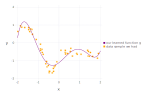

In [2]:
using CurveFit
using Polynomials

N = 50
x_train = 4*(rand(N)-0.5)
y_train = 1.8*tanh(3.2*x_train + 0.8)- 2.5*tanh(2.1*x_train + 1.2)-0.2*tanh(0.1*x_train - 0.5) + noise*randn(size(x_train))

X = [ones(N); x_train; x_train.^2; x_train.^3; x_train.^4; x_train.^5]'
w = pinv(X) * y_train'
ynew = X * w

p = poly_fit(x_train, y_train, 5)

xi=-2:0.01:2

plot(layer(x=xi, y=polyval(Poly(p), xi), Geom.line, Theme( default_color=colorant"purple")),
     layer(x=x_train, y=ynew, Geom.point, Theme( default_color=colorant"orange")),
     Guide.manual_color_key("", ["our learned function g(x)", "data sample we had"], ["purple", "orange"]))

3. In-sample error
------------------
We now wish to calculate the in-sample error $E_{in}$ to measure how good is our learned function $g$ at predicting the data distribution we had:

$$E_{in}(g) = \frac{1}{N} \sum_{n=1}^{N} (g(x_n) - y_n)^2 $$


In [3]:
E_in = mean((polyval(Poly(p), x_train) - y_train).^2)

0.05835153313691306

So our training model has an $E_{in} \approx 0.58$. Not too bad.  
Let us now plot the solution hypothesis (our learned function $g$) next to the data sample distribution we had. The in-sample error is represented as the vertical red lines that measure the distance between a point $(x_n, y_n)$ and its corresponding $(x_n, g(x_n))$ 

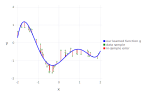

In [4]:
y = (y_train + polyval(Poly(p), x_train))./2
ymins = min(y_train, polyval(Poly(p), x_train))
ymaxs = max(y_train, polyval(Poly(p), x_train))

plot(layer(x=x_data, y=polyval(Poly(p), x_data), Geom.line, Theme(line_width = 1.5pt, default_color = colorant"blue")),
     layer(x=x_train, y=y_train, Geom.point, Theme( default_point_size=1.5pt, default_color = colorant"green")),
     layer(x=x_train, y=y, ymin=ymins, ymax=ymaxs, Geom.point, Geom.errorbar, Theme(line_width = 0.8pt, default_point_size=0pt, default_color = colorant"red", errorbar_cap_length = 0.01pt )),
     Guide.manual_color_key("", ["our learned function g(x)", "data sample", "in-sample error"], ["blue", "green", "red"]))

4. Generalization issues: out-of-sample error
---------------------------------------------
A more realistic measure of how good our learned function is would be the _out-of-sample error_, that is:

In [5]:
E_out = mean((polyval(Poly(p), x_data) - y_data).^2)

0.07502837688307523

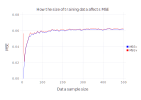

In [8]:
MSEc = zeros(100)
MSEv = zeros(100)

for j=1:100
    N = j * 5
    total_MSEc=0
    total_MSEv=0
    for i=1:100
        x_train = 4*(rand(N)-0.5)
        y_train = 1.8*tanh(3.2*x_train + 0.8)- 2.5*tanh(2.1*x_train + 1.2)-0.2*tanh(0.1*x_train - 0.5) + noise*randn(size(x_train))
    
        p = poly_fit(x_train, y_train, 5)
        err_emp = sum((polyval(Poly(p), x_train) - y_train).^2)/N
        err_gen = sum((polyval(Poly(p), x_data) - y_data).^2)/NUMPOINTS
        total_MSEc = total_MSEc + err_emp
        total_MSEv = total_MSEc + err_gen
    end
    MSEc[j] = total_MSEc/100
    MSEv[j] = total_MSEv/100
end

plot(layer(x=5:5:500, y=MSEc, Geom.line, Theme(line_width=0.5pt, default_color=colorant"blue")),
     layer(x=5:5:500, y=MSEv, Geom.line, Theme(line_width=0.5pt, default_color=colorant"red")),
     Guide.manual_color_key("", ["MSEc", "MSEv"], ["blue", "red"]), Guide.xlabel("Data sample size"), Guide.ylabel("MSE"),
     Guide.title("How the size of training data affects MSE"))

5. Overfitting
-----------------------------------------------------------
However, there is a catch in our lineal regresion algorithm: we specifically chose our hypothesis set to be the class of all polinomials of degree five. In other words, we _assumed_ that our solution will take the form:

$$ g(x) = w_0 + w_1x + w_2x^2 + w_3x^3 + w_4x^4 + w_5x^5 $$

What would have happened had we chosen to inculde polinomials of a degree less or greater than five? What correlation there is between the number of parameters in our solution, and our error measurments?

The following expermiment plots the values obtained for bothe the in-sample error and the out-of-sample error as we increase the number of parameters from 1 to 30:


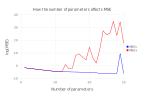

In [7]:
N = 30
MSEc = zeros(30)
MSEv = zeros(30)

for degree=1:30
    total_MSEc=0
    total_MSEv=0
    for i=1:100
        x_train = 4*(rand(N)-0.5)
        y_train = 1.8*tanh(3.2*x_train + 0.8)- 2.5*tanh(2.1*x_train + 1.2)-0.2*tanh(0.1*x_train - 0.5) + noise*randn(size(x_train))
    
        p = poly_fit(x_train, y_train, degree)
        err_emp = sum((polyval(Poly(p), x_train) - y_train).^2)/N
        err_gen = sum((polyval(Poly(p), x_data) - y_data).^2)/NUMPOINTS
        total_MSEc = total_MSEc + err_emp
        total_MSEv = total_MSEc + err_gen
    end
    MSEc[degree] = total_MSEc/100
    MSEv[degree] = total_MSEv/100
end

plot(layer(x=1:30, y=log(MSEc), Geom.line, Theme(line_width=1pt, default_color=colorant"blue")),
     layer(x=1:30, y=log(MSEv), Geom.line, Theme(line_width=1pt, default_color=colorant"red")),
     Guide.manual_color_key("", ["MSEc", "MSEv"], ["blue", "red"]), Guide.xlabel("Number of parameters"), Guide.ylabel("log(MSE)"),
     Guide.title("How the number of parameters affects MSE"))

6. Wait, did we actually _learn_?
---------------------------------
Let's be honest, linear regression
doesn't really look like '_learning_', in the sense that the hypothesis $g$ comes
from an analytic solution (matrix inversion and multiplications) rather than
from iterative learning steps. __Well, as long as the hypothesis $g$ has a decent
out-of-sample error, then learning has occurred__. Linear regression is a rare
case where we have an analytic formula for learning that is easy to evaluate.
This is one of the reasons why the technique is so widely used.